# Vibe Coding: Generative Ambient Audio & Visuals

A comprehensive notebook for creating ambient soundscapes and synchronized procedural visuals with interactive controls, export capabilities, and reproducibility features.

## Section 1: Environment Setup & Package Installation

In [ ]:
# Install required packages
import subprocess
import sys

packages = [
    'numpy',
    'scipy',
    'matplotlib',
    'pillow',
    'imageio',
    'soundfile',
    'ipywidgets',
    'scikit-image',
    'ipykernel'
]

for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

print("✓ All packages installed successfully!")

In [ ]:
# Check runtime environment
import platform
print(f"Python Version: {platform.python_version()}")
print(f"Platform: {platform.system()} {platform.release()}")

# Display kernel info
import IPython
print(f"IPython Version: {IPython.__version__}")

## Section 2: Imports and Global Constants

In [2]:
import numpy as np
import scipy.signal as signal
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Audio, display
from PIL import Image, ImageDraw
import imageio
import soundfile as sf
import ipywidgets as widgets
from ipywidgets import interactive, IntSlider, FloatSlider, Dropdown, Button, Output
import json
import os
from pathlib import Path
from datetime import datetime

# Set up plotting style
plt.style.use('dark_background')
%matplotlib inline

ModuleNotFoundError: No module named 'imageio'

In [ ]:
# Global Constants
SAMPLE_RATE = 44100  # 44.1 kHz standard audio sampling rate
DEFAULT_DURATION = 8.0  # seconds
FIGURE_SIZE = (12, 8)  # matplotlib figure size
RNG_SEED = 42  # for reproducibility

# Set random seed
np.random.seed(RNG_SEED)

print("=== Global Constants ===")
print(f"Sample Rate: {SAMPLE_RATE} Hz")
print(f"Default Duration: {DEFAULT_DURATION} seconds")
print(f"Figure Size: {FIGURE_SIZE}")
print(f"RNG Seed: {RNG_SEED}")
print(f"Total Samples: {int(SAMPLE_RATE * DEFAULT_DURATION)}")

## Section 3: Generate Basic Tones and Ambient Pads

In [ ]:
def generate_sine_wave(frequency, duration, amplitude=0.5, sr=SAMPLE_RATE):
    """Generate a sine wave at given frequency."""
    t = np.linspace(0, duration, int(sr * duration), False)
    return amplitude * np.sin(2 * np.pi * frequency * t)

def generate_sawtooth_wave(frequency, duration, amplitude=0.5, sr=SAMPLE_RATE):
    """Generate a sawtooth wave at given frequency."""
    t = np.linspace(0, duration, int(sr * duration), False)
    return amplitude * signal.sawtooth(2 * np.pi * frequency * t)

def adsr_envelope(attack, decay, sustain, release, duration, sr=SAMPLE_RATE):
    """Generate ADSR envelope."""
    samples = int(sr * duration)
    env = np.zeros(samples)
    
    a_samples = int(sr * attack)
    d_samples = int(sr * decay)
    r_samples = int(sr * release)
    s_samples = samples - a_samples - d_samples - r_samples
    
    if a_samples > 0:
        env[:a_samples] = np.linspace(0, 1, a_samples)
    if d_samples > 0:
        env[a_samples:a_samples + d_samples] = np.linspace(1, sustain, d_samples)
    if s_samples > 0:
        env[a_samples + d_samples:a_samples + d_samples + s_samples] = sustain
    if r_samples > 0:
        env[-r_samples:] = np.linspace(sustain, 0, r_samples)
    
    return env

def generate_detuned_pad(base_freq, detune_cents=10, duration=DEFAULT_DURATION, 
                         attack=0.2, decay=1.0, sustain=0.7, release=2.0):
    """Generate detuned pad with multiple voices."""
    # Create multiple detuned voices
    detune_factor = 2 ** (detune_cents / 1200)
    
    voice1 = generate_sine_wave(base_freq, duration, amplitude=0.3)
    voice2 = generate_sine_wave(base_freq * detune_factor, duration, amplitude=0.3)
    voice3 = generate_sine_wave(base_freq / detune_factor, duration, amplitude=0.2)
    
    # Apply envelope
    env = adsr_envelope(attack, decay, sustain, release, duration)
    
    # Mix voices
    pad = (voice1 + voice2 + voice3) * env / 3
    
    # Normalize
    pad = pad / (np.max(np.abs(pad)) + 1e-6)
    
    return pad

# Test: Generate a simple ambient pad
test_pad = generate_detuned_pad(110, detune_cents=15)
print(f"Generated pad shape: {test_pad.shape}")
print(f"Peak amplitude: {np.max(np.abs(test_pad)):.4f}")

In [ ]:
# Play test pad
display(Audio(test_pad, rate=SAMPLE_RATE))

## Section 4: Procedural Noise and Filtered Textures

In [ ]:
def generate_white_noise(duration, amplitude=0.1, sr=SAMPLE_RATE):
    """Generate white noise."""
    samples = int(sr * duration)
    return amplitude * np.random.randn(samples)

def generate_pink_noise(duration, amplitude=0.1, sr=SAMPLE_RATE):
    """Generate pink noise using spectral filtering."""
    samples = int(sr * duration)
    white = np.random.randn(samples)
    
    # Create pink noise by low-pass filtering
    b, a = signal.butter(1, 0.1)
    pink = signal.filtfilt(b, a, white)
    
    return amplitude * pink / (np.max(np.abs(pink)) + 1e-6)

def apply_lowpass_filter(audio, cutoff_freq, sr=SAMPLE_RATE, order=4):
    """Apply IIR lowpass filter."""
    nyquist = sr / 2
    normalized_cutoff = cutoff_freq / nyquist
    
    if normalized_cutoff >= 1.0:
        return audio
    
    b, a = signal.butter(order, normalized_cutoff)
    return signal.filtfilt(b, a, audio)

def filter_with_lfo_modulation(audio, base_cutoff, lfo_depth, lfo_freq, sr=SAMPLE_RATE):
    """Apply time-varying filter with LFO modulation."""
    duration = len(audio) / sr
    t = np.linspace(0, duration, len(audio))
    
    # Create LFO (sine wave modulation)
    lfo = lfo_depth * np.sin(2 * np.pi * lfo_freq * t)
    cutoff_freq = base_cutoff + lfo
    cutoff_freq = np.clip(cutoff_freq, 20, sr/2 - 1)
    
    # Apply time-varying filter (simple implementation)
    output = np.zeros_like(audio)
    window_size = int(sr * 0.01)  # 10ms windows
    
    for i in range(0, len(audio) - window_size, window_size):
        cf = cutoff_freq[i]
        filtered = apply_lowpass_filter(audio[i:i+window_size], cf)
        output[i:i+window_size] = filtered
    
    return output

# Test: Generate filtered noise
test_noise = generate_pink_noise(DEFAULT_DURATION, amplitude=0.3)
filtered_noise = filter_with_lfo_modulation(test_noise, base_cutoff=1000, 
                                           lfo_depth=500, lfo_freq=0.5)

print(f"Generated filtered noise shape: {filtered_noise.shape}")
print(f"Peak amplitude: {np.max(np.abs(filtered_noise)):.4f}")
display(Audio(filtered_noise, rate=SAMPLE_RATE))

## Section 5: Create Static Generative Visuals (Palettes & Gradients)

In [ ]:
def create_color_palette(hue_start, hue_end, num_colors=256, saturation=0.8, value=0.9):
    """Create a color palette using HSV color space."""
    from matplotlib.colors import hsv_to_rgb
    
    hues = np.linspace(hue_start, hue_end, num_colors)
    palette = np.zeros((num_colors, 3))
    
    for i, hue in enumerate(hues):
        palette[i] = hsv_to_rgb([hue % 1.0, saturation, value])
    
    return (palette * 255).astype(np.uint8)

def create_gradient_image(palette, width=512, height=512, gradient_type='horizontal'):
    """Create a gradient image using a palette."""
    if gradient_type == 'horizontal':
        gradient = np.linspace(0, 1, width)
        gradient = np.tile(gradient, (height, 1))
    elif gradient_type == 'vertical':
        gradient = np.linspace(0, 1, height)
        gradient = np.tile(gradient.reshape(-1, 1), (1, width))
    elif gradient_type == 'radial':
        x = np.linspace(-1, 1, width)
        y = np.linspace(-1, 1, height)
        X, Y = np.meshgrid(x, y)
        gradient = np.sqrt(X**2 + Y**2) / np.sqrt(2)
        gradient = np.clip(gradient, 0, 1)
    
    # Map gradient to palette
    indices = (gradient * (len(palette) - 1)).astype(int)
    image = palette[indices]
    
    return Image.fromarray(image)

def create_procedural_pattern(width=512, height=512, scale=50):
    """Create procedural patterns using noise."""
    from skimage.util import random_noise
    
    # Generate noise-based pattern
    pattern = np.random.rand(height, width)
    
    # Apply smoothing for coherence
    from scipy.ndimage import gaussian_filter
    pattern = gaussian_filter(pattern, sigma=scale/10)
    
    # Normalize to 0-1
    pattern = (pattern - pattern.min()) / (pattern.max() - pattern.min() + 1e-6)
    
    return pattern

# Create test palettes and visuals
palette1 = create_color_palette(0, 0.3)  # Blue to cyan
palette2 = create_color_palette(0.3, 0.7)  # Cyan to green to yellow
palette3 = create_color_palette(0.8, 1.0)  # Magenta to red

# Create and display gradient
gradient_img = create_gradient_image(palette2, gradient_type='radial')
plt.figure(figsize=(8, 8))
plt.imshow(gradient_img)
plt.title("Radial Gradient Example")
plt.axis('off')
plt.tight_layout()
plt.show()

# Create procedural pattern
pattern = create_procedural_pattern(512, 512, scale=30)
plt.figure(figsize=(8, 8))
plt.imshow(pattern, cmap='viridis')
plt.title("Procedural Noise Pattern")
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()

## Section 6: Animated Visuals (Parametric & Procedural)

In [ ]:
def create_lissajous_frames(num_frames=120, width=512, height=512, 
                           freq_x=3, freq_y=2, phase=0):
    """Create Lissajous curve animation frames."""
    frames = []
    
    for frame_idx in range(num_frames):
        img = Image.new('RGB', (width, height), color='black')
        draw = ImageDraw.Draw(img)
        
        # Generate Lissajous curve points
        t = np.linspace(0, 2 * np.pi, 1000)
        phase_offset = (frame_idx / num_frames) * 2 * np.pi
        
        x = np.sin(freq_x * t + phase_offset + phase)
        y = np.sin(freq_y * t + phase_offset)
        
        # Scale to image dimensions
        x_pix = ((x + 1) / 2) * (width - 1)
        y_pix = ((y + 1) / 2) * (height - 1)
        
        # Draw curve
        for i in range(len(t) - 1):
            draw.line([(x_pix[i], y_pix[i]), (x_pix[i+1], y_pix[i+1])], 
                     fill=(100, 200, 255), width=2)
        
        frames.append(np.array(img))
    
    return frames

def create_flowing_noise_frames(num_frames=120, width=512, height=512, flow_speed=0.1):
    """Create flowing noise animation frames."""
    from scipy.ndimage import gaussian_filter
    
    frames = []
    
    for frame_idx in range(num_frames):
        # Create flowing noise using time-dependent perturbation
        time_offset = frame_idx * flow_speed
        
        x = np.linspace(0, 4 * np.pi, width)
        y = np.linspace(0, 4 * np.pi, height)
        X, Y = np.meshgrid(x, y)
        
        # Flowing pattern
        noise = np.sin(X + time_offset) * np.cos(Y + time_offset * 0.7)
        noise = gaussian_filter(noise, sigma=20)
        
        # Normalize and colorize
        noise = (noise - noise.min()) / (noise.max() - noise.min() + 1e-6)
        
        # Apply palette
        palette = create_color_palette(time_offset % 1.0, 
                                       (time_offset + 0.3) % 1.0, 
                                       saturation=0.7)
        indices = (noise * (len(palette) - 1)).astype(int)
        img_array = palette[indices]
        
        frames.append(img_array)
    
    return frames

# Test: Create and display a few frames
print("Creating Lissajous animation frames...")
lissajous_frames = create_lissajous_frames(num_frames=8, freq_x=3, freq_y=2)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(lissajous_frames[i])
    ax.set_title(f"Frame {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## Section 7: Audio-Visual Synchronization

In [ ]:
def extract_audio_features(audio, sr=SAMPLE_RATE, hop_length=512):
    """Extract audio features for visualization synchronization."""
    # RMS envelope
    rms = np.array([
        np.sqrt(np.mean(audio[i:i+hop_length]**2))
        for i in range(0, len(audio), hop_length)
    ])
    
    # FFT-based frequency bands
    fft_result = np.abs(fft(audio))
    freqs = fftfreq(len(audio), 1/sr)
    
    # Low, mid, high bands
    low_band = np.mean(np.abs(fft_result[(freqs > 0) & (freqs < 250)]))
    mid_band = np.mean(np.abs(fft_result[(freqs >= 250) & (freqs < 4000)]))
    high_band = np.mean(np.abs(fft_result[(freqs >= 4000) & (freqs < sr/2)]))
    
    return {
        'rms': rms,
        'rms_normalized': rms / (np.max(rms) + 1e-6),
        'low_band': low_band,
        'mid_band': mid_band,
        'high_band': high_band
    }

def synchronize_visuals_to_audio(audio, frames, sr=SAMPLE_RATE, fps=30):
    """Map audio features to visual parameters."""
    features = extract_audio_features(audio)
    rms = features['rms_normalized']
    
    # Map RMS to frame intensity/color modulation
    num_frames = len(frames)
    rms_interp = np.interp(
        np.linspace(0, len(rms), num_frames),
        np.arange(len(rms)),
        rms
    )
    
    synchronized_frames = []
    for i, frame in enumerate(frames):
        # Modulate brightness based on RMS
        intensity = rms_interp[i]
        modulated = (frame.astype(float) * (0.5 + 0.5 * intensity)).astype(np.uint8)
        synchronized_frames.append(modulated)
    
    return synchronized_frames, features

# Test synchronization
test_audio = generate_detuned_pad(110, duration=4.0)
test_frames = create_lissajous_frames(num_frames=120, freq_x=3, freq_y=2)
sync_frames, features = synchronize_visuals_to_audio(test_audio, test_frames)

print("Audio features extracted:")
print(f"  RMS min/max: {np.min(features['rms']):.4f} / {np.max(features['rms']):.4f}")
print(f"  Low band: {features['low_band']:.4f}")
print(f"  Mid band: {features['mid_band']:.4f}")
print(f"  High band: {features['high_band']:.4f}")

## Section 8: Interactive Controls with ipywidgets

In [ ]:
class VibeGenerator:
    """Interactive vibe generator with state management."""
    
    def __init__(self):
        self.current_audio = None
        self.current_frames = None
        self.state = {
            'tempo': 100,
            'base_freq': 110,
            'detune': 15,
            'duration': 4.0,
            'palette': 'blue_cyan',
            'visual_style': 'lissajous',
            'seed': 42
        }
    
    def update_state(self, **kwargs):
        """Update generator state."""
        self.state.update(kwargs)
        np.random.seed(self.state['seed'])
    
    def generate_audio(self):
        """Generate audio based on current state."""
        base_freq = self.state['base_freq']
        detune = self.state['detune']
        duration = self.state['duration']
        
        self.current_audio = generate_detuned_pad(
            base_freq, detune_cents=detune, duration=duration
        )
        return self.current_audio
    
    def generate_visuals(self):
        """Generate visuals based on current state."""
        num_frames = int(self.state['duration'] * 30)  # 30 fps
        
        if self.state['visual_style'] == 'lissajous':
            self.current_frames = create_lissajous_frames(num_frames=num_frames)
        else:
            self.current_frames = create_flowing_noise_frames(num_frames=num_frames)
        
        return self.current_frames
    
    def render(self):
        """Generate and display audio/visuals."""
        audio = self.generate_audio()
        frames = self.generate_visuals()
        
        # Display audio
        display(Audio(audio, rate=SAMPLE_RATE))
        
        # Display first frame
        plt.figure(figsize=(6, 6))
        plt.imshow(frames[0])
        plt.title(f"Visual Preview ({self.state['visual_style']})")
        plt.axis('off')
        plt.show()

# Create interactive UI
generator = VibeGenerator()

# Create widgets
tempo_slider = IntSlider(value=100, min=60, max=180, step=1, description='Tempo (BPM):')
freq_slider = IntSlider(value=110, min=20, max=880, step=10, description='Base Freq (Hz):')
detune_slider = IntSlider(value=15, min=0, max=100, step=1, description='Detune (cents):')
duration_slider = FloatSlider(value=4.0, min=1.0, max=10.0, step=0.5, description='Duration (s):')
style_dropdown = Dropdown(options=['lissajous', 'flowing_noise'], value='lissajous', description='Visual Style:')

def on_change(change):
    """Callback when widgets change."""
    generator.update_state(
        tempo=tempo_slider.value,
        base_freq=freq_slider.value,
        detune=detune_slider.value,
        duration=duration_slider.value,
        visual_style=style_dropdown.value
    )

# Attach callbacks
tempo_slider.observe(on_change, 'value')
freq_slider.observe(on_change, 'value')
detune_slider.observe(on_change, 'value')
duration_slider.observe(on_change, 'value')
style_dropdown.observe(on_change, 'value')

# Create buttons
render_button = Button(description='Generate & Play')
render_output = Output()

def on_render_click(b):
    with render_output:
        render_output.clear_output()
        generator.render()

render_button.on_click(on_render_click)

# Display UI
print("=== Vibe Generator Controls ===")
display(widgets.VBox([
    tempo_slider,
    freq_slider,
    detune_slider,
    duration_slider,
    style_dropdown,
    render_button,
    render_output
]))

## Section 9: Export Audio and Animations

In [1]:
def export_audio(audio, filename, sr=SAMPLE_RATE):
    """Export audio to WAV file."""
    output_dir = Path('./exports')
    output_dir.mkdir(exist_ok=True)
    
    filepath = output_dir / filename
    sf.write(str(filepath), audio, sr)
    
    print(f"✓ Audio exported to {filepath}")
    return filepath

def export_animation_gif(frames, filename, duration=100):
    """Export frames to GIF."""
    output_dir = Path('./exports')
    output_dir.mkdir(exist_ok=True)
    
    filepath = output_dir / filename
    imageio.mimsave(str(filepath), frames, duration=duration)
    
    print(f"✓ GIF exported to {filepath}")
    return filepath

def export_animation_mp4(frames, audio, filename, fps=30, sr=SAMPLE_RATE):
    """Export frames and audio to MP4."""
    output_dir = Path('./exports')
    output_dir.mkdir(exist_ok=True)
    
    # First, export audio as temporary WAV
    temp_audio_path = output_dir / 'temp_audio.wav'
    sf.write(str(temp_audio_path), audio, sr)
    
    # Export video without audio
    video_path = output_dir / filename
    writer = imageio.get_writer(str(video_path), fps=fps)
    for frame in frames:
        writer.append_data(frame)
    writer.close()
    
    # Combine audio and video using ffmpeg (if available)
    try:
        import subprocess
        output_with_audio = output_dir / f"_audio_{filename}"
        subprocess.run([
            'ffmpeg', '-i', str(video_path), '-i', str(temp_audio_path),
            '-c:v', 'copy', '-c:a', 'aac', '-shortest',
            str(output_with_audio), '-y'
        ], capture_output=True)
        temp_audio_path.unlink()
        video_path.unlink()
        print(f"✓ MP4 with audio exported to {output_with_audio}")
        return output_with_audio
    except:
        print(f"✓ MP4 (video only) exported to {video_path}")
        temp_audio_path.unlink()
        return video_path

# Example: Export current generator output
if generator.current_audio is not None:
    # Export audio
    audio_path = export_audio(generator.current_audio, 'vibe_ambient.wav')
    
    # Export animation
    if generator.current_frames is not None:
        gif_path = export_animation_gif(generator.current_frames, 'vibe_visual.gif', duration=50)

print("\nExport functions ready. Use export_audio(), export_animation_gif(), or export_animation_mp4()")

NameError: name 'SAMPLE_RATE' is not defined

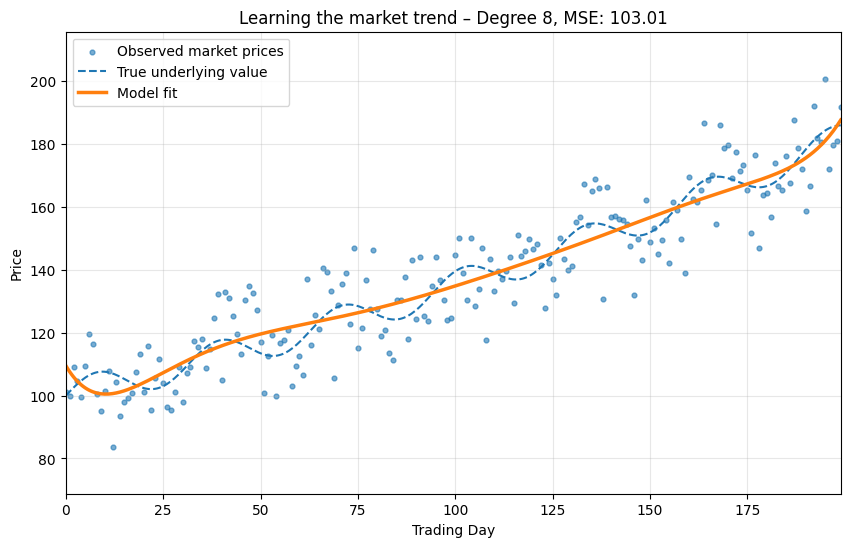

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def generate_market_data(num_days=200, seed=0):
    """
    Simulate a 'true' stock price and noisy observed market prices.
    - true_prices: smooth "fair value" path (unknown in real life)
    - observed_prices: what the market actually trades at (noisy)
    """
    rng = np.random.default_rng(seed)
    days = np.arange(num_days)

    # Underlying trend: exponential growth + cyclical swings
    true_prices = 100 * np.exp(0.003 * days) + 5 * np.sin(0.2 * days)

    # Market noise (random shocks)
    noise = rng.normal(loc=0.0, scale=10.0, size=num_days)
    observed_prices = true_prices + noise

    return days, true_prices, observed_prices


def make_improving_model_animation(max_degree=8, interval_ms=800):
    """
    Create a JS animation (for Jupyter) showing a model slowly
    improving its fit to noisy market data by increasing polynomial degree.
    """
    days, true_prices, observed_prices = generate_market_data()

    # Dense grid for smooth model curves
    t_dense = np.linspace(days.min(), days.max(), 400)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter: noisy market prices (what you actually see)
    ax.scatter(days, observed_prices, s=12, alpha=0.6,
               label="Observed market prices")

    # Plot the underlying “true” fair value (we usually don't know this in real life)
    true_line, = ax.plot(
        t_dense,
        100 * np.exp(0.003 * t_dense) + 5 * np.sin(0.2 * t_dense),
        linestyle="--",
        linewidth=1.5,
        label="True underlying value"
    )

    # Line that will show our model's prediction, improving over frames
    pred_line, = ax.plot([], [], linewidth=2.5, label="Model fit")

    ax.set_xlabel("Trading Day")
    ax.set_ylabel("Price")
    ax.set_title("Fitting market trend...")
    ax.legend(loc="upper left")
    ax.grid(True, alpha=0.3)

    # Nice axis limits
    ax.set_xlim(days.min(), days.max())
    pad = 15
    ax.set_ylim(observed_prices.min() - pad, observed_prices.max() + pad)

    def init():
        pred_line.set_data([], [])
        ax.set_title("Fitting market trend...")
        return pred_line,

    def animate(frame):
        """
        Each frame increases polynomial degree:
        degree 1 = straight line (very simple),
        degree 2, 3, ... = more flexible model.
        """
        degree = frame + 1  # 1..max_degree

        # Fit polynomial regression of given degree to the noisy market prices
        coef = np.polyfit(days, observed_prices, degree)
        y_pred_dense = np.polyval(coef, t_dense)

        # Compute mean squared error on the observed market prices
        y_pred_on_data = np.polyval(coef, days)
        mse = np.mean((y_pred_on_data - observed_prices) ** 2)

        pred_line.set_data(t_dense, y_pred_dense)
        ax.set_title(
            f"Learning the market trend – Degree {degree}, MSE: {mse:0.2f}"
        )
        return pred_line,

    ani = FuncAnimation(
        fig,
        animate,
        frames=max_degree,
        init_func=init,
        interval=interval_ms,
        blit=True,
        repeat=True
    )

    # Return a JS-based animation that displays directly in Jupyter
    return HTML(ani.to_jshtml())


# === Run this in Jupyter to display the animation ===
make_improving_model_animation(max_degree=8, interval_ms=800)

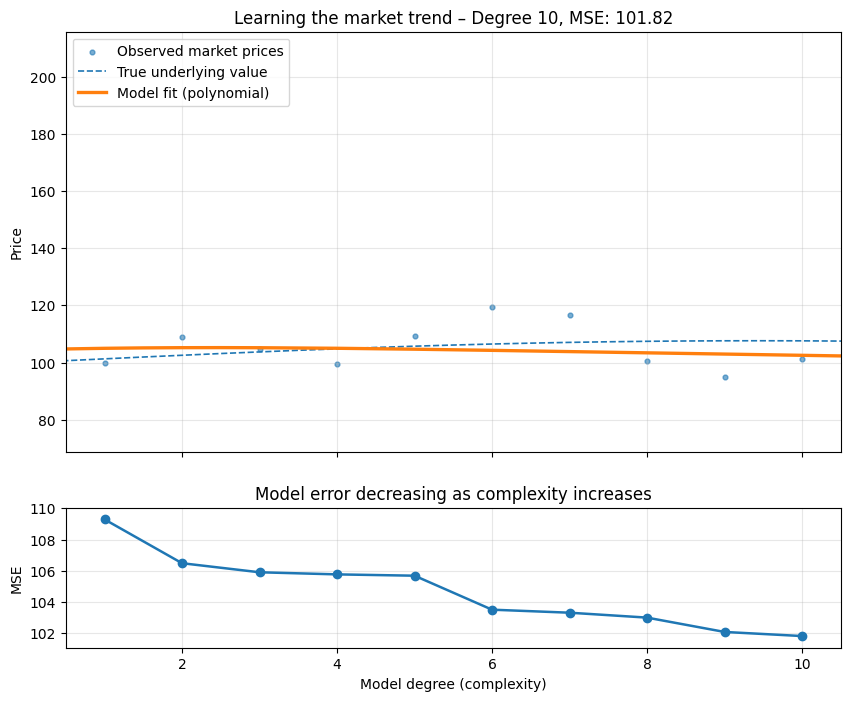

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def generate_market_data(num_days=200, seed=0):
    """
    Simulate a 'true' stock price and noisy observed market prices.
    """
    rng = np.random.default_rng(seed)
    days = np.arange(num_days)

    # Underlying trend: exponential growth + cyclical swings
    true_prices = 100 * np.exp(0.003 * days) + 5 * np.sin(0.2 * days)

    # Market noise (random shocks)
    noise = rng.normal(loc=0.0, scale=10.0, size=num_days)
    observed_prices = true_prices + noise

    return days, true_prices, observed_prices


def improving_model_with_error_curve(max_degree=10, interval_ms=700):
    days, true_prices, observed_prices = generate_market_data()
    t_dense = np.linspace(days.min(), days.max(), 400)

    # Precompute true path on dense grid
    true_dense = 100 * np.exp(0.003 * t_dense) + 5 * np.sin(0.2 * t_dense)

    # For the error plot
    degrees = np.arange(1, max_degree + 1)
    mse_history = np.full_like(degrees, fill_value=np.nan, dtype=float)

    # --- FIGURE LAYOUT: 2 rows, shared x ---
    fig, (ax_price, ax_err) = plt.subplots(
        2, 1, figsize=(10, 8), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # TOP: price chart
    ax_price.scatter(days, observed_prices, s=12, alpha=0.6,
                     label="Observed market prices")

    true_line, = ax_price.plot(
        t_dense, true_dense,
        linestyle="--", linewidth=1.2,
        label="True underlying value"
    )

    pred_line, = ax_price.plot([], [], linewidth=2.4,
                               label="Model fit (polynomial)")

    ax_price.set_ylabel("Price")
    ax_price.set_title("Learning the market trend")
    ax_price.legend(loc="upper left")
    ax_price.grid(True, alpha=0.3)

    pad = 15
    ax_price.set_xlim(days.min(), days.max())
    ax_price.set_ylim(observed_prices.min() - pad,
                      observed_prices.max() + pad)

    # BOTTOM: error vs degree
    mse_line, = ax_err.plot([], [], marker="o", linewidth=1.8)
    ax_err.set_xlabel("Model degree (complexity)")
    ax_err.set_ylabel("MSE")
    ax_err.set_title("Model error decreasing as complexity increases")
    ax_err.grid(True, alpha=0.3)
    ax_err.set_xlim(0.5, max_degree + 0.5)

    # We'll set y-limits dynamically after first few frames

    def init():
        pred_line.set_data([], [])
        mse_line.set_data([], [])
        return pred_line, mse_line

    def animate(frame):
        """
        Each frame:
        - increase polynomial degree
        - refit to noisy prices
        - update top chart (fit line)
        - update bottom chart (error vs degree)
        """
        degree = frame + 1  # 1..max_degree

        # Fit polynomial regression of given degree
        coef = np.polyfit(days, observed_prices, degree)
        y_pred_dense = np.polyval(coef, t_dense)

        # Compute MSE on observed prices
        y_pred_data = np.polyval(coef, days)
        mse = np.mean((y_pred_data - observed_prices) ** 2)
        mse_history[degree - 1] = mse

        # --- update top chart ---
        pred_line.set_data(t_dense, y_pred_dense)
        ax_price.set_title(
            f"Learning the market trend – Degree {degree}, MSE: {mse:0.2f}"
        )

        # --- update bottom chart ---
        mask = ~np.isnan(mse_history)
        mse_line.set_data(degrees[mask], mse_history[mask])

        if np.sum(mask) > 1:
            # Nice dynamic y-limits for error curve
            y_min = np.nanmin(mse_history[mask])
            y_max = np.nanmax(mse_history[mask])
            margin = 0.1 * (y_max - y_min if y_max > y_min else 1.0)
            ax_err.set_ylim(max(0, y_min - margin), y_max + margin)
        else:
            # Default until we have enough points
            ax_err.set_ylim(0, mse * 1.5)

        return pred_line, mse_line

    ani = FuncAnimation(
        fig,
        animate,
        frames=max_degree,
        init_func=init,
        interval=interval_ms,
        blit=True,
        repeat=True
    )

    return HTML(ani.to_jshtml())


# === RUN THIS IN JUPYTER ===
improving_model_with_error_curve(max_degree=10, interval_ms=700)